# Michelin Restaurants in France - *Arrondissements*

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

Importing restaurant data

In [2]:
france_data = pd.read_csv("../../data/France/all_restaurants.csv")
france_data.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937


In [3]:
print(france_data.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude']


----
&nbsp;
Demographics data from [INSEE](https://statistiques-locales.insee.fr/#c=indicator&view=map5)

In [4]:
stats_locale = pd.read_csv("../../../../ExtraData/Demographics/arrondissements_data_2023.csv", sep=';', header=None)
# Use the third row as column headers
stats_locale.columns = stats_locale.iloc[2]
# Drop the metadata rows
stats_locale = stats_locale.drop([0, 1, 2]).reset_index(drop=True)
print(stats_locale.columns.tolist())

['Code', 'Libellé', 'Nb de pers. non scolarisées de 15 ans ou + 2021', 'Salaire net horaire moyen 2022', 'Population municipale 2022', 'Densité de population (historique depuis 1876) 2021', 'Taux de pauvreté 2021']


In [5]:
stats_locale = stats_locale.rename(columns={
    'Code': 'code',
    'Libellé': 'arrondissement',
    'Taux de pauvreté 2021': 'poverty_rate(%)',
    'Salaire net horaire moyen 2022': 'average_net_hourly_wage(€)',
    'Population municipale 2022': 'municipal_population',
    'Densité de population (historique depuis 1876) 2021': 'population_density(inhabitants/sq_km)',
})
stats_locale = stats_locale[['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)',
                             'poverty_rate(%)', 'average_net_hourly_wage(€)']]
stats_locale.head()

2,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,126468,78.8,10.1,15.98
1,012,Bourg-en-Bresse,345948,119.2,9.1,16.31
2,013,Gex,104770,252,12.4,15.82
3,014,Nantua,94103,104.3,16.3,14.61
4,021,Château-Thierry,69416,62.6,14.6,14.95


In [6]:
print(stats_locale.columns.tolist())

['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)']


Loading in [GeoJSON data](https://github.com/gregoiredavid/france-geojson/blob/master/arrondissements-avec-outre-mer.geojson)

In [7]:
# Load the GeoJSON file
geoJSON_df = gpd.read_file('../../../../ExtraData/Geodata/arrondissements-avec-outre-mer.geojson')
geoJSON_df.head()

,code,nom,geometry
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4..."
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6..."
3,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


In [8]:
print(geoJSON_df.columns.tolist())

['code', 'nom', 'geometry']


----
&nbsp;
### Removing *outre-mers*

In [9]:
# We leverage the format of the first two digits of the 'code' column
# where 01 - 95 represents mainland france
geoJSON_df = geoJSON_df.sort_values(by='code')
geoJSON_df = geoJSON_df[~geoJSON_df['code'].str.startswith('97')]
geoJSON_df = geoJSON_df.reset_index(drop=True)
geoJSON_df.shape

(320, 3)

In [10]:
# We again remove '97' leveraging a pattern
stats_locale = stats_locale.sort_values(by='code')
stats_locale = stats_locale[~stats_locale['code'].str.startswith('97')]
stats_locale = stats_locale.reset_index(drop=True)
stats_locale.shape

(320, 6)

It's good news the dataframes have the same length

----
&nbsp;
### Looking for discrepancies in the `nom`, `arrondissement` columns

In [11]:
set1 = set(stats_locale['arrondissement'].unique())
set2 = set(geoJSON_df['nom'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [12]:
print("In set1 but not in set2: ", set1 - set2)
print("\nIn set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {'La Roche-sur-Yon', 'La Châtre', 'Le Mans', 'Le Puy-en-Velay', 'La Rochelle', 'Le Blanc', 'La Flèche', 'Le Raincy', "L'Haÿ-les-Roses", "Les Sables-d'Olonne", 'Le Havre', 'Val-de-Briey', 'Le Vigan', 'Les Andelys', 'La Tour-du-Pin'}

In set2 but not in set1:  {'Rochelle', 'Mans', 'Briey', 'Châtre', 'Vigan', 'Tour-du-Pin', 'Blanc', 'Roche-sur-Yon', 'Flèche', 'Haÿ-les-Roses', 'Andelys', "Sables-d'Olonne", 'Havre', 'Raincy', 'Puy-en-Velay'}


We will add articles to the GeoDataFrame by creating a reverse mapping dictionary.

In [13]:
def clean_name(name):
    for prefix in ['Le ', 'La ', 'Les ', "L'"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    return name.strip()

def match_articleless_to_full(articleless_set, full_set):
    """
    Returns a mapping from articleless names (e.g. 'Mans') to full names (e.g. 'Le Mans')
    """
    # Build a reverse map: cleaned name → full name with article
    cleaned_to_full = {clean_name(name): name for name in full_set}

    # Match articleless name to full name via cleaned lookup
    mapping = {}
    for name in articleless_set:
        full_name = cleaned_to_full.get(name)
        if full_name:
            mapping[name] = full_name

    return mapping

In [14]:
# set1_clean = set(map(clean_name, stats_locale['arrondissement'].unique()))
# set2_clean = set(map(clean_name, geoJSON_df['nom'].unique()))

reversed_map = match_articleless_to_full(set2, set1)

# Update 'stats_locale' with the new names
# stats_locale['arrondissement'] = stats_locale['arrondissement'].apply(reversed_map)
geoJSON_df['nom'] = geoJSON_df['nom'].map(
    lambda x: reversed_map.get(clean_name(x), x)
)

In [15]:
set1 = set(stats_locale['arrondissement'].unique())   # Full names
set2 = set(geoJSON_df['nom'].unique())
# Check for discrepancies again
print("In set1 but not in set2: ", set1 - set2)
print("\nIn set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {'Val-de-Briey'}

In set2 but not in set1:  {'Briey'}


In [16]:
# Correct the discrepancy manually
if 'Val-de-Briey' in set1 and 'Briey' in set2:
    geoJSON_df['nom'] = geoJSON_df['nom'].replace('Briey', 'Val-de-Briey')

In [17]:
article_mask = stats_locale['arrondissement'].str.startswith(('Le ', 'La ', 'Les ', "L'"))
print("Rows with definite articles:", article_mask.sum())
print("Total rows:", len(stats_locale))

Rows with definite articles: 14
Total rows: 320


In [18]:
article_mask = geoJSON_df['nom'].str.startswith(('Le ', 'La ', 'Les ', "L'"))
print("Rows with definite articles:", article_mask.sum())
print("Total rows:", len(geoJSON_df))

Rows with definite articles: 14
Total rows: 320


----
&nbsp;
### Mapping individual restaurants to *arrondissements* based on (latitude, longitude) Geospatial data

In [19]:
# Convert france_data to GeoDataFrame
geometry = [Point(xy) for xy in zip(france_data.longitude, france_data.latitude)]
france_geo = gpd.GeoDataFrame(france_data, geometry=geometry)

In [20]:
france_geo.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude,geometry
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494,POINT (2.36452 48.85549)
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240,POINT (6.59696 45.83024)
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722,POINT (2.3146 48.87172)
3,Arpège,84 rue de Varenne,"Paris, 75007",75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754,POINT (2.31701 48.85575)
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937,POINT (2.25072 48.86394)


In [21]:
france_geo.crs = "EPSG:4326"

In [22]:
joined_data = gpd.sjoin(france_geo, geoJSON_df[['nom', 'geometry']], predicate='within', how='left')
joined_data.rename(columns={'nom': 'arrondissement'}, inplace=True)

In [23]:
# Convert the GeoDataFrame to a normal DataFrame
france_df = pd.DataFrame(joined_data)

# Drop the 'geometry' and 'index_right' columns
france_df = france_df.drop(columns=['geometry', 'index_right'])
print(france_df.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude', 'arrondissement']


In [24]:
new_order = ['name', 'address', 'location', 'arrondissement', 'department_num',
             'department', 'capital', 'region', 'price', 'cuisine', 'url',
             'award', 'stars', 'greenstar', 'longitude', 'latitude']
france_df = france_df[new_order]
france_df.head(10)

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",Paris,75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",Bonneville,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",Paris,75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937
5,Le Cinq,"Four Seasons Hotel George V, 31 avenue George-V","Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.fourseasons.com,3 Stars,3.0,0,2.300861,48.868760
6,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,0,5.352048,43.280257
7,Kei,5 rue du Coq-Héron,"Paris, 75001",Paris,75,Paris,Paris,Île-de-France,€€€€,"Modern Cuisine, Creative",https://www.restaurant-kei.fr/,3 Stars,3.0,0,2.342285,48.864395
8,L'Oustau de Baumanière,Mas de Baumanière,"Les Baux-de-Provence, 13520",Arles,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.baumaniere.com,3 Stars,3.0,1,4.787363,43.740266
9,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,0,2.342159,48.858815


In [25]:
france_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2985 entries, 0 to 2984
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2985 non-null   object 
 1   address         2985 non-null   object 
 2   location        2985 non-null   object 
 3   arrondissement  2978 non-null   object 
 4   department_num  2985 non-null   object 
 5   department      2985 non-null   object 
 6   capital         2985 non-null   object 
 7   region          2985 non-null   object 
 8   price           2985 non-null   object 
 9   cuisine         2985 non-null   object 
 10  url             2831 non-null   object 
 11  award           2985 non-null   object 
 12  stars           2985 non-null   float64
 13  greenstar       2985 non-null   int64  
 14  longitude       2985 non-null   float64
 15  latitude        2985 non-null   float64
dtypes: float64(3), int64(1), object(12)
memory usage: 396.4+ KB


In [26]:
# Unique arrondissement in the dataset
france_df.arrondissement.nunique()

288

----
&nbsp;
### Adding Parisien *arrondissement municipaux*

In [27]:
all_france = france_df.copy()

In [28]:
import certifi
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://en.wikipedia.org/wiki/Arrondissements_of_Paris'
tables = pd.read_html(url)

In [29]:
# The table of interest is found by inspection
paris_arr = tables[1]
paris_arr.head()

,Coat of arms,"Arrondissement (R for Right Bank, L for Left Bank)",Name,Area (km2),Population (2017 estimate),Density (2017) (inhabitants per km2),Peak of population,Mayor (2020–2026)
0,NaN,1st (Ier) R Administratively part of Paris Centre,Louvre,5.59 km2 (2.16 sq mi),"100,196 (Paris Centre)","17,924 (Paris Center)",before 1861,Ariel Weil (PS)
1,NaN,2nd (IIe) R Administratively part of Paris Centre,Bourse,5.59 km2 (2.16 sq mi),"100,196 (Paris Centre)","17,924 (Paris Center)",before 1861,Ariel Weil (PS)
2,NaN,3rd (IIIe) R Administratively part of Paris Ce...,Temple,5.59 km2 (2.16 sq mi),"100,196 (Paris Centre)","17,924 (Paris Center)",before 1861,Ariel Weil (PS)
3,NaN,4th (IVe) R Administratively part of Paris Centre,Hôtel-de-Ville,5.59 km2 (2.16 sq mi),"100,196 (Paris Centre)","17,924 (Paris Center)",before 1861,Ariel Weil (PS)
4,NaN,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),59631,23477,1911,Florence Berthout (DVD)


In [30]:
print(paris_arr.columns.tolist())

['Coat of arms', 'Arrondissement (R for Right Bank, L for Left Bank)', 'Name', 'Area (km2)', 'Population (2017 estimate)', 'Density (2017) (inhabitants per km2)', 'Peak of population', 'Mayor (2020–2026)']


In [31]:
# Drop specified columns from the DataFrame
paris_arr = paris_arr.drop(columns=['Coat of arms', 'Area (km2)', 'Population (2017 estimate)', 'Density (2017) (inhabitants per km2)', 'Peak of population', 'Mayor (2020–2026)'])

paris_arr = paris_arr.rename(columns={'Arrondissement (R for Right Bank, L for Left Bank)': 'arrondissement', 'Name': 'name'})

In [32]:
# Extract the first part of the 'arrondissement' using regex
paris_arr['arrondissement'] = paris_arr['arrondissement'].str.extract(r'(\d+\w{2})')
paris_arr.head()

,arrondissement,name
0,1st,Louvre
1,2nd,Bourse
2,3rd,Temple
3,4th,Hôtel-de-Ville
4,5th,Panthéon


Search `france_data` for 'Paris'

In [33]:
paris_rows = all_france[all_france['location'].str.contains('Paris', case=False, na=False)]
paris_rows.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",Paris,75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",Paris,75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937
5,Le Cinq,"Four Seasons Hotel George V, 31 avenue George-V","Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.fourseasons.com,3 Stars,3.0,0,2.300861,48.868760


In [34]:
# Mask to identify rows with 'arrondissement' == 'Paris'
mask_paris = all_france['arrondissement'] == 'Paris'

# Extract the last two digits from the postal code for the mask
all_france.loc[mask_paris, 'postal_digits'] = all_france.loc[mask_paris, 'location'].str[-2:].astype(int)

# Overwrite the 'arrondissement' column for the mask
all_france.loc[mask_paris, 'arrondissement'] = all_france.loc[mask_paris, 'postal_digits']

# Drop the temporary 'postal_digits' column
all_france.drop(columns=['postal_digits'], inplace=True, errors='ignore')  # Using errors='ignore' to ensure code doesn't break if column doesn't exist

In [35]:
all_france.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",4.0,75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",Bonneville,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",8.0,75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",7.0,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",16.0,75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937


In [36]:
# Filter out Paris rows
paris_rows = all_france[all_france['department'].str.contains('Paris', case=False, na=False)].copy()

In [37]:
# Extract numbers from "1st", "2nd", etc. in paris_arr to a new temporary column
paris_arr['arr_num'] = paris_arr['arrondissement'].str.extract(r'(\d+)').astype(float)

# Create a dictionary that maps these numbers to the tuple (arrondissement, name)
paris_tuple_dict = dict(zip(paris_arr['arr_num'], zip(paris_arr['arrondissement'], paris_arr['name'])))
paris_tuple_dict = {k: f"{v[0]} ({v[1]})" for k, v in paris_tuple_dict.items()}

In [38]:
# Map the arrondissement values in all_france to the paris_tuple_dict
new_arr_values = all_france['arrondissement'].map(paris_tuple_dict)

# Fill NaN values with existing values from arrondissement column
new_arr_values.fillna(all_france['arrondissement'], inplace=True)

In [39]:
# Assign the new series to the arrondissement column
all_france['arrondissement'] = new_arr_values
all_france.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
1,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",Bonneville,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,0,6.596963,45.830240
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",7th (Palais-Bourbon),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937


In [40]:
print(all_france.region.unique())

['Île-de-France' 'Auvergne-Rhône-Alpes' "Provence-Alpes-Côte d'Azur"
 'Bourgogne-Franche-Comté' 'Brittany' 'Nouvelle-Aquitaine'
 'Pays de la Loire' 'Grand Est' 'Occitanie' 'Hauts-de-France'
 'Centre-Val de Loire' 'Corsica' 'Normandy']


In [41]:
# all_france has some English region names -> need to map them to French
region_mapping = {
    'Brittany': 'Bretagne',
    'Corsica': 'Corse',
    'Normandy': 'Normandie'
}

# Map the English region names to the French ones used in df
all_france['region'] = all_france['region'].replace(region_mapping)

In [42]:
print(all_france.region.unique())

['Île-de-France' 'Auvergne-Rhône-Alpes' "Provence-Alpes-Côte d'Azur"
 'Bourgogne-Franche-Comté' 'Bretagne' 'Nouvelle-Aquitaine'
 'Pays de la Loire' 'Grand Est' 'Occitanie' 'Hauts-de-France'
 'Centre-Val de Loire' 'Corse' 'Normandie']


#### Exporting as `csv` file

In [43]:
# Export the DataFrame to a .csv file
all_france.to_csv('../../data/France/all_restaurants(arrondissements).csv', index=False)

----
&nbsp;
## Subsetting for Paris
#### Creating `paris_restaurants.geojson`

In [44]:
paris = all_france[all_france['department'].str.contains('Paris', case=False, na=False)].copy()
print(f"Shape: {paris.shape}")
paris.head()

Shape: (460, 16)


,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",7th (Palais-Bourbon),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937
5,Le Cinq,"Four Seasons Hotel George V, 31 avenue George-V","Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.fourseasons.com,3 Stars,3.0,0,2.300861,48.868760


In [45]:
print(f"Columns:\n{paris.columns}")

Columns:
Index(['name', 'address', 'location', 'arrondissement', 'department_num',
       'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award',
       'stars', 'greenstar', 'longitude', 'latitude'],
      dtype='object')


In [46]:
print(f"No unique arrondissements: {len(paris.arrondissement.unique())}\n{paris.arrondissement.unique()}")

No unique arrondissements: 20
['4th (Hôtel-de-Ville)' '8th (Élysée)' '7th (Palais-Bourbon)'
 '16th (Passy)' '1st (Louvre)' '9th (Opéra)' '3rd (Temple)'
 '6th (Luxembourg)' '12th (Reuilly)' '2nd (Bourse)'
 '17th (Batignolles-Monceau)' '5th (Panthéon)' '11th (Popincourt)'
 '15th (Vaugirard)' '14th (Observatoire)' '18th (Butte-Montmartre)'
 '13th (Gobelins)' '10th (Entrepôt)' '19th (Buttes-Chaumont)'
 '20th (Ménilmontant)']


----
&nbsp;
### Adding Parisien shape files

In [47]:
# Create a subset of the data based on unique arrondissements and relevant columns
paris_subset = paris[['location', 'arrondissement', 'department_num', 'department', 'capital', 'region']].drop_duplicates()

# Display the unique arrondissements and subsetted data
print(f"Unique Arrondissements: {paris_subset['arrondissement'].nunique()}")
paris_subset.head()

Unique Arrondissements: 20


,location,arrondissement,department_num,department,capital,region
0,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France
2,"Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France
3,"Paris, 75007",7th (Palais-Bourbon),75,Paris,Paris,Île-de-France
4,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France
7,"Paris, 75001",1st (Louvre),75,Paris,Paris,Île-de-France


In [48]:
# Load the GeoJSON file
geoJSON_paris = gpd.read_file('../../../../ExtraData/Geodata/paris_arrondissements.geojson')
print(f"Shape: {geoJSON_paris.shape}")
geoJSON_paris.head()

Shape: (20, 10)


,n_sq_ar,c_ar,c_arinsee,l_ar,l_aroff,n_sq_co,surface,perimetre,geom_x_y,geometry
0,750000010,10,75110,10ème Ardt,Entrepôt,750001537,2.891739e+06,6739.375055,"{ ""lon"": 2.3607284878474522, ""lat"": 48.8761300...","POLYGON ((2.36469 48.88437, 2.36485 48.88436, ..."
1,750000018,18,75118,18ème Ardt,Buttes-Montmartre,750001537,5.996051e+06,9916.464176,"{ ""lon"": 2.3481605195620396, ""lat"": 48.8925692...","POLYGON ((2.3658 48.88554, 2.36469 48.88437, 2..."
2,750000006,6,75106,6ème Ardt,Luxembourg,750001537,2.153096e+06,6483.686786,"{ ""lon"": 2.3328979990533147, ""lat"": 48.8491303...","POLYGON ((2.34459 48.85405, 2.34428 48.85375, ..."
3,750000009,9,75109,9ème Ardt,Opéra,750001537,2.178303e+06,6471.588290,"{ ""lon"": 2.3374575434825444, ""lat"": 48.8771635...","POLYGON ((2.33978 48.88203, 2.33982 48.88202, ..."
4,750000016,16,75116,16ème Ardt,Passy,750001537,1.637254e+07,17416.109657,"{ ""lon"": 2.2619707883645428, ""lat"": 48.8603921...","POLYGON ((2.27427 48.87837, 2.27749 48.87796, ..."


In [49]:
print(f"Columns: {geoJSON_paris.columns.tolist()}")

Columns: ['n_sq_ar', 'c_ar', 'c_arinsee', 'l_ar', 'l_aroff', 'n_sq_co', 'surface', 'perimetre', 'geom_x_y', 'geometry']


In [50]:
print(f"No unique arrondissements: {len(geoJSON_paris.l_ar.unique())}\n{geoJSON_paris.l_ar.unique()}")

No unique arrondissements: 20
['10ème Ardt' '18ème Ardt' '6ème Ardt' '9ème Ardt' '16ème Ardt' '1er Ardt'
 '3ème Ardt' '14ème Ardt' '2ème Ardt' '12ème Ardt' '15ème Ardt'
 '20ème Ardt' '11ème Ardt' '7ème Ardt' '17ème Ardt' '4ème Ardt'
 '8ème Ardt' '19ème Ardt' '13ème Ardt' '5ème Ardt']


#### Creating a new numerical column in both `paris_subset` and `geoJSON_paris`

In [51]:
# Extract the numerical part from the 'arrondissement' column in paris_subset
paris_subset['arrondissement_num'] = paris_subset['arrondissement'].str.extract(r'(\d+)').astype(int)

# Extract the numerical part from the 'l_ar' column in geoJSON_paris
geoJSON_paris['arrondissement_num'] = geoJSON_paris['l_ar'].str.extract(r'(\d+)').astype(int)

In [52]:
# Get unique arrondissement numbers from both
paris_arrondissements = set(paris_subset['arrondissement_num'].unique())
geojson_arrondissements = set(geoJSON_paris['arrondissement_num'].unique())

# Find out which arrondissements are missing in geoJSON
missing_arrondissements = geojson_arrondissements - paris_arrondissements
print(f"Missing Arrondissements: {missing_arrondissements}")

Missing Arrondissements: set()


In [53]:
# Convert the 'arrondissement_num' column to int, ignoring errors in case of any non-convertible values
paris_subset['arrondissement_num'] = pd.to_numeric(paris_subset['arrondissement_num'], errors='coerce')
paris_subset = paris_subset.sort_values(by='arrondissement_num').reset_index(drop=True)
paris_subset.tail()

,location,arrondissement,department_num,department,capital,region,arrondissement_num
16,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,16
17,"Paris, 75017",17th (Batignolles-Monceau),75,Paris,Paris,Île-de-France,17
18,"Paris, 75018",18th (Butte-Montmartre),75,Paris,Paris,Île-de-France,18
19,"Paris, 75019",19th (Buttes-Chaumont),75,Paris,Paris,Île-de-France,19
20,"Paris, 75020",20th (Ménilmontant),75,Paris,Paris,Île-de-France,20


In [54]:
# Merge the two DataFrames on 'arrondissement_num'
paris_geo_merged = paris_subset.merge(geoJSON_paris[['arrondissement_num', 'geometry']],
                                      on='arrondissement_num', how='left')

In [55]:
paris_geo_merged = paris_geo_merged.drop(columns=['arrondissement_num'])
paris_geo_merged = paris_geo_merged.drop(index=15)
print(f"Shape: {paris_geo_merged.shape}")
paris_geo_merged.tail()

Shape: (20, 7)


,location,arrondissement,department_num,department,capital,region,geometry
16,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,"POLYGON ((2.27427 48.87837, 2.27749 48.87796, ..."
17,"Paris, 75017",17th (Batignolles-Monceau),75,Paris,Paris,Île-de-France,"POLYGON ((2.29517 48.87396, 2.29504 48.87378, ..."
18,"Paris, 75018",18th (Butte-Montmartre),75,Paris,Paris,Île-de-France,"POLYGON ((2.3658 48.88554, 2.36469 48.88437, 2..."
19,"Paris, 75019",19th (Buttes-Chaumont),75,Paris,Paris,Île-de-France,"POLYGON ((2.38943 48.90122, 2.39014 48.90108, ..."
20,"Paris, 75020",20th (Ménilmontant),75,Paris,Paris,Île-de-France,"POLYGON ((2.41277 48.87547, 2.41284 48.87524, ..."


In [56]:
paris_geo_merged

,location,arrondissement,department_num,department,capital,region,geometry
0,"Paris, 75001",1st (Louvre),75,Paris,Paris,Île-de-France,"POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,"Paris, 75002",2nd (Bourse),75,Paris,Paris,Île-de-France,"POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
2,"Paris, 75003",3rd (Temple),75,Paris,Paris,Île-de-France,"POLYGON ((2.36383 48.8675, 2.36389 48.86747, 2..."
3,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,"POLYGON ((2.36851 48.85573, 2.369 48.85374, 2...."
4,"Paris, 75005",5th (Panthéon),75,Paris,Paris,Île-de-France,"POLYGON ((2.36443 48.84614, 2.36484 48.84584, ..."
5,"Paris, 75006",6th (Luxembourg),75,Paris,Paris,Île-de-France,"POLYGON ((2.34459 48.85405, 2.34428 48.85375, ..."
6,"Paris, 75007",7th (Palais-Bourbon),75,Paris,Paris,Île-de-France,"POLYGON ((2.30088 48.85118, 2.29932 48.85217, ..."
7,"Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,"POLYGON ((2.32584 48.86956, 2.32569 48.86954, ..."
8,"Paris, 75009",9th (Opéra),75,Paris,Paris,Île-de-France,"POLYGON ((2.33978 48.88203, 2.33982 48.88202, ..."
9,"Paris, 75010",10th (Entrepôt),75,Paris,Paris,Île-de-France,"POLYGON ((2.36469 48.88437, 2.36485 48.88436, ..."


#### Adding restaurant counts and locations

In [57]:
print(f"Parisien Restos: {paris.shape}")
paris.head()

Parisien Restos: (460, 16)


,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,greenstar,longitude,latitude
0,L'Ambroisie,9 place des Vosges,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,0,2.364521,48.855494
2,Épicure,"Le Bristol, 112 rue du Faubourg-Saint-Honoré","Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.oetkercollection.com/fr/hotels/le-...,3 Stars,3.0,0,2.314598,48.871722
3,Arpège,84 rue de Varenne,"Paris, 75007",7th (Palais-Bourbon),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.alain-passard.com/,3 Stars,3.0,1,2.317013,48.855754
4,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,0,2.250718,48.863937
5,Le Cinq,"Four Seasons Hotel George V, 31 avenue George-V","Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Modern Cuisine,https://www.fourseasons.com,3 Stars,3.0,0,2.300861,48.868760


In [58]:
paris_data_copy = paris.copy()

# Create dummy variables for each category of 'star'
paris_data_copy['green_stars'] = paris_data_copy['greenstar'].apply(lambda x: 1 if x == 1 else 0)
paris_data_copy['selected'] = paris_data_copy['stars'].apply(lambda x: 1 if x == 0.25 else 0)
paris_data_copy['bib_gourmand'] = paris_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
paris_data_copy['1_star'] = paris_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
paris_data_copy['2_star'] = paris_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
paris_data_copy['3_star'] = paris_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

In [59]:
# Group by 'arrondissement' and sum 'bib', '1_star', '2_star' and '3_star'
paris_arrondissement_grouped = paris_data_copy.groupby('arrondissement')[['green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star']].sum()

In [60]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
paris_arrondissement_grouped['total_stars'] = paris_arrondissement_grouped['1_star']*1 + paris_arrondissement_grouped['2_star']*2 + paris_arrondissement_grouped['3_star']*3

# Create a 'total' column = sum of restaurants
paris_arrondissement_grouped['starred_restaurants'] =  paris_arrondissement_grouped['1_star'] + paris_arrondissement_grouped['2_star'] + paris_arrondissement_grouped['3_star']

paris_arrondissement_grouped = paris_arrondissement_grouped.reset_index()
if 'index' in paris_arrondissement_grouped.columns:
    paris_arrondissement_grouped = paris_arrondissement_grouped.rename(columns={'index': 'arrondissement'})

In [61]:
print(f"Shape: {paris_arrondissement_grouped.shape}")
paris_arrondissement_grouped.head()

Shape: (20, 9)


,arrondissement,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,10th (Entrepôt),0,15,1,0,0,0,0,0
1,11th (Popincourt),2,23,3,7,0,0,7,7
2,12th (Reuilly),1,10,1,1,1,0,3,2
3,13th (Gobelins),0,9,1,0,0,0,0,0
4,14th (Observatoire),0,9,3,1,0,0,1,1


In [62]:
# Merge the grouped data with the geospatial data
paris_final_merged = paris_geo_merged.merge(paris_arrondissement_grouped, on='arrondissement', how='left')

#### Adding individual restaurants

In [63]:
print(paris.columns.tolist())

['name', 'address', 'location', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude']


In [64]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_paris_arrond = paris[['stars', 'arrondissement', 'latitude', 'longitude']]

# Aggregate latitude and longitude into lists
grouped = location_paris_arrond.groupby(['stars', 'arrondissement']).agg({'latitude': list, 'longitude': list})

# Zip the lists of latitudes and longitudes into coordinates
grouped['coordinates'] = grouped.apply(lambda x: list(zip(x['latitude'], x['longitude'])), axis=1)

# Convert to dictionary
location_paris_arrond = grouped['coordinates'].to_dict()

In [65]:
# Create a mapping from star values to string labels
star_label_mapping = {
    0.25: 'Selected',
    0.5: 'Bib',
    1: '1',
    2: '2',
    3: '3'
}

# Now create a function to map these dictionaries to original DataFrame
def map_locations_arrond(row):
    return {star_label_mapping[stars]: location_paris_arrond.get((stars, row['arrondissement'])) for stars in [0.25, 0.5, 1, 2, 3]}

paris_final_merged['locations'] = paris_final_merged.apply(map_locations_arrond, axis=1)

In [66]:
# Drop 'Paris, ' prefix from 'location' and rename to 'code'
paris_final_merged['code'] = paris_final_merged['location'].str.replace('Paris, ', '')
paris_final_merged = paris_final_merged.drop(columns=['location'])

# Reorder columns so 'code' is first and 'geometry' is last
cols = ['code'] + [col for col in paris_final_merged.columns if col not in ['code', 'geometry']] + ['geometry']
paris_final_merged = paris_final_merged[cols]

In [67]:
# Convert the DataFrame into a GeoDataFrame using the 'geometry' column
paris_final_merged_gdf = gpd.GeoDataFrame(paris_final_merged, geometry='geometry')

In [68]:
print(f"Shape: {paris_final_merged_gdf.shape}")
print(f"Type: {type(paris_final_merged_gdf)}")
paris_final_merged_gdf.head()

Shape: (20, 16)
Type: <class 'geopandas.geodataframe.GeoDataFrame'>


,code,arrondissement,department_num,department,capital,region,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,locations,geometry
0,75001,1st (Louvre),75,Paris,Paris,Île-de-France,0,21,1,9,2,2,19,13,"{'Selected': [(48.8653808, 2.3297932), (48.864...","POLYGON ((2.32801 48.86992, 2.32997 48.86851, ..."
1,75002,2nd (Bourse),75,Paris,Paris,Île-de-France,0,15,1,7,1,0,9,8,"{'Selected': [(48.8660245, 2.3489295), (48.869...","POLYGON ((2.35152 48.86443, 2.35095 48.86341, ..."
2,75003,3rd (Temple),75,Paris,Paris,Île-de-France,0,13,0,2,0,0,2,2,"{'Selected': [(48.8620352, 2.3510841), (48.863...","POLYGON ((2.36383 48.8675, 2.36389 48.86747, 2..."
3,75004,4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,0,10,0,3,0,1,6,4,"{'Selected': [(48.8531761, 2.364001), (48.8595...","POLYGON ((2.36851 48.85573, 2.369 48.85374, 2...."
4,75005,5th (Panthéon),75,Paris,Paris,Île-de-France,0,13,1,7,0,0,7,7,"{'Selected': [(48.839, 2.3505), (48.8528713, 2...","POLYGON ((2.36443 48.84614, 2.36484 48.84584, ..."


#### Export Paris data as GeoJSON file

In [69]:
paris_final_merged_gdf.to_file('../../data/France/geodata/paris_restaurants.geojson', driver='GeoJSON')

----
&nbsp;
## Rest of France
#### Grouping by *arrondissement* based on number of Michelin stars

In [70]:
france_data_copy = france_df.copy()

# Create dummy variables for each category of 'star'
france_data_copy['green_stars'] = france_data_copy['greenstar'].apply(lambda x: 1 if x == 1 else 0)
france_data_copy['selected'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.25 else 0)
france_data_copy['bib_gourmand'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
france_data_copy['1_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data_copy['2_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data_copy['3_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By *`arrondissement`*
We sort `france_data` by total number of awarded restaurants

In [71]:
# Group by 'arrondissement' and sum 'bib', '1_star', '2_star' and '3_star'
arrondissement_grouped = france_data_copy.groupby('arrondissement')[['green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Create a copy for plotting
arrondissement_grouped_two = arrondissement_grouped.copy()

`arrondissement_grouped` is created to be merged with the demographics data

In [72]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
arrondissement_grouped['total_stars'] = arrondissement_grouped['1_star']*1 + arrondissement_grouped['2_star']*2 + arrondissement_grouped['3_star']*3

# Create a 'total' column = sum of restaurants
arrondissement_grouped['starred_restaurants'] =  arrondissement_grouped['1_star'] + arrondissement_grouped['2_star'] + arrondissement_grouped['3_star']

# Sort the dataframe by the 'total_stars' column in descending order
arrondissement_grouped.sort_values('total_stars', ascending=True, inplace=True)

In [73]:
arrondissement_grouped.head()

,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
arrondissement,,,,,,,,
Abbeville,1,5,1,0,0,0,0,0
Lesparre-Médoc,0,2,0,0,0,0,0,0
Évreux,0,0,1,0,0,0,0,0
Limoux,0,1,0,0,0,0,0,0
Lodève,0,3,1,0,0,0,0,0


----
&nbsp;
## Plotting starred restaurants by *`arrondissement`*

We use `arrondissement_grouped_two` for plotting whilst excluding Paris

In [74]:
# Create a 'total_starred' column - sum of starred restaurants
arrondissement_grouped_two['total_starred'] = arrondissement_grouped_two['1_star'] + arrondissement_grouped_two['2_star'] + arrondissement_grouped_two['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
arrondissement_grouped_two.sort_values('total_starred', ascending=True, inplace=True)

In [75]:
# Exclude 'Paris'
arrondissement_grouped_no_paris = arrondissement_grouped_two[arrondissement_grouped_two.index.get_level_values('arrondissement') != 'Paris']

In [76]:
# Sort by 'total_starred' in descending order and keep the top 10
arrondissement_grouped_top10 = arrondissement_grouped_no_paris.sort_values('total_starred', ascending=False).head(10)

# Drop the 'bib_gourmand' & 'total' columns
arrondissement_grouped_top10 = arrondissement_grouped_top10.drop(columns=['green_stars', 'selected', 'bib_gourmand', 'total_starred'])

# Reverse the order of the DataFrame
arrondissement_grouped_top10 = arrondissement_grouped_top10.iloc[::-1]

Plot the data

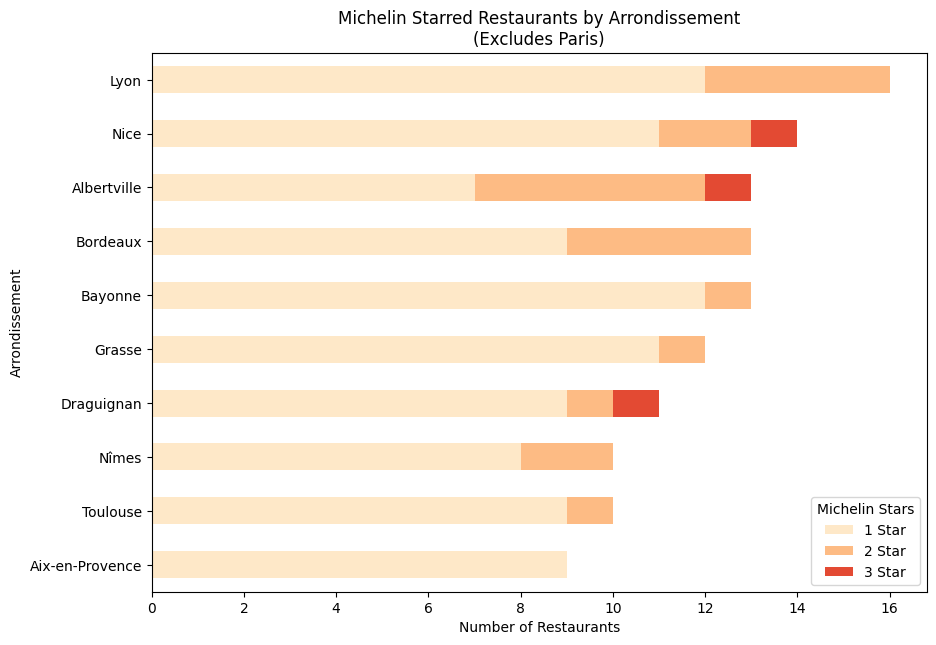

In [77]:
# Create a horizontal stacked bar plot
arrondissement_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Arrondissement\n(Excludes Paris)')
plt.ylabel('Arrondissement')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
#### We now cascade merges from the smallest granularity (arrondissement) up to the highest (region) using the department as an intermediary linking point.

#### 1. Extract departmental code from `geoJSON_df`

In [78]:
geoJSON_df['department_num'] = geoJSON_df['code'].str[:2]
print(f"Shape: {geoJSON_df.shape}")
print(f"Columns: {geoJSON_df.columns.tolist()}")
geoJSON_df.head(3)

Shape: (320, 4)
Columns: ['code', 'nom', 'geometry', 'department_num']


,code,nom,geometry,department_num
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...",01
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4...",01
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6...",01


#### 2. Extract department name from file produced in `France_Departments_Regions.ipynb`

In [79]:
departments = gpd.read_file("../../../../ExtraData/Geodata/departements.geojson")
print(f"Shape: {departments.shape}")
print(f"Columns: {departments.columns.tolist()}")
departments.head()

Shape: (96, 3)
Columns: ['code', 'nom', 'geometry']


,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.7908, 3..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [80]:
# Merge the dataframes on the appropriate columns
merged_geo_df = pd.merge(geoJSON_df[['code', 'nom', 'geometry', 'department_num']],
                         departments[['code', 'nom']],
                         left_on='department_num', right_on='code',
                         how='left', suffixes=('_arrondissement', '_department'))

In [81]:
print(f"Shape: {merged_geo_df.shape}")

Shape: (320, 6)


In [82]:
print(f"Columns: {merged_geo_df.columns.tolist()}")

Columns: ['code_arrondissement', 'nom_arrondissement', 'geometry', 'department_num', 'code_department', 'nom_department']


In [83]:
# Drop 'code_department'
merged_geo_df.drop('code_department', axis=1, inplace=True)

# Rename columns
column_rename_map = {
    'nom_arrondissement': 'arrondissement',
    'nom_department': 'department'
}
merged_geo_df.rename(columns=column_rename_map, inplace=True)

# Rearrange columns
new_order = ['code_arrondissement', 'arrondissement', 'department_num', 'department', 'geometry']
merged_geo_df = merged_geo_df[new_order]
merged_geo_df.head()

,code_arrondissement,arrondissement,department_num,department,geometry
0,01001,Belley,01,Ain,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4..."
2,01003,Gex,01,Ain,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6..."
3,01004,Nantua,01,Ain,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 3. Extract the region from `france_df`

In [84]:
# 1. Create a copy of france_df and retain only the columns of interest
france_subset = france_df[['department_num', 'department', 'capital', 'region']].copy()

# Drop duplicates based on 'department_num'
france_subset = france_subset.drop_duplicates(subset='department_num')
print(f"Shape: {france_subset.shape}")

Shape: (96, 4)


We know there are 96 departments. Therefore, *all good!*

In [85]:
# Sort by 'department_num'
france_subset = france_subset.sort_values(by='department_num').reset_index(drop=True)

In [86]:
print(f"Shape: {france_subset.shape}")
france_subset.head()

Shape: (96, 4)


,department_num,department,capital,region
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


In [87]:
france_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   department_num  96 non-null     object
 1   department      96 non-null     object
 2   capital         96 non-null     object
 3   region          96 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


#### 4. Merge `france_subset` with `geoJSON_df` on `department_num`

In [88]:
merged_df = pd.merge(france_subset, geoJSON_df, on="department_num", how="inner")
print(f"Shape geo: {geoJSON_df.shape}\nShape merged: {merged_df.shape}")

Shape geo: (320, 4)
Shape merged: (320, 7)


In [89]:
merged_df.head()

,department_num,department,capital,region,code,nom,geometry
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4..."
2,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01003,Gex,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6..."
3,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02,Aisne,Laon,Hauts-de-France,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 5. Merge above with `stats_locale` on 'nom' & 'arrondissement'

In [90]:
print(f"Shape: {stats_locale.shape}")
stats_locale.head()

Shape: (320, 6)


2,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,126468,78.8,10.1,15.98
1,012,Bourg-en-Bresse,345948,119.2,9.1,16.31
2,013,Gex,104770,252,12.4,15.82
3,014,Nantua,94103,104.3,16.3,14.61
4,021,Château-Thierry,69416,62.6,14.6,14.95


In [91]:
geo_stats = pd.merge(stats_locale, merged_df, left_on='arrondissement', right_on='nom', how='inner')

In [92]:
print(f"Shape: {geo_stats.shape}")
print(f"Unique regions: {geo_stats['region'].nunique()}")
print(f"Unique departments: {geo_stats['department_num'].nunique()}")
print(f"Unique arrondissements: {geo_stats['arrondissement'].nunique()}")
print(f"Columns:\n{geo_stats.columns.tolist()}")

Shape: (320, 13)
Unique regions: 13
Unique departments: 96
Unique arrondissements: 320
Columns:
['code_x', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'department_num', 'department', 'capital', 'region', 'code_y', 'nom', 'geometry']


In [93]:
# Drop 'code_'
geo_stats.drop(['code_x'], axis=1, inplace=True)
geo_stats.rename(columns={'code_y': 'code'}, inplace=True)

In [94]:
# Rearrange columns
new_order = ['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
geo_stats = geo_stats[new_order]
geo_stats.head()

,code,arrondissement,department_num,department,capital,region,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,126468,78.8,10.1,15.98,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,345948,119.2,9.1,16.31,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,104770,252,12.4,15.82,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6..."
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,94103,104.3,16.3,14.61,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,69416,62.6,14.6,14.95,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Merging Michelin Star by *arrondissement* with `geo_stats`

In [95]:
print(f"Rows in `geo_stats`: {len(geo_stats)}")

# We index the multi-indexed df
arrondissement_grouped.reset_index(inplace=True)
print(f"Rows in `arrondissement_grouped`: {len(arrondissement_grouped)}")

Rows in `geo_stats`: 320
Rows in `arrondissement_grouped`: 288


In [96]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

print(f"\nIn arrondissement_grouped but not in geo_stats:\n{set1 - set2}")
print(f"\nIn geostats but not in arrondissement_grouped:\n{set2 - set1}")

Sets equal? False

In arrondissement_grouped but not in geo_stats:
set()

In geostats but not in arrondissement_grouped:
{'Bar-sur-Aube', 'Clamecy', 'Bellac', "Saint-Jean-d'Angély", 'Mauriac', 'Péronne', 'Vervins', 'La Châtre', 'Le Blanc', 'Sedan', 'Castellane', 'Saint-Quentin', 'Argenteuil', 'Château-Gontier', 'Parthenay', 'Cosne-Cours-sur-Loire', 'Vouziers', 'Saint-Denis', 'Lens', 'Châteaudun', 'Nogent-sur-Seine', 'Saint-Dizier', 'Foix', 'Castelsarrasin', 'Bressuire', 'Vitry-le-François', 'Rethel', 'Val-de-Briey', 'Redon', 'Avesnes-sur-Helpe', 'Toul', 'Corte'}


There are a number of *arrondissement* without Michelin rated restaurants.

These will be written with zero values

In [97]:
print(f"Columns: {arrondissement_grouped.columns.tolist()}")
arrondissement_grouped.head()

Columns: ['arrondissement', 'green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


,arrondissement,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,1,5,1,0,0,0,0,0
1,Lesparre-Médoc,0,2,0,0,0,0,0,0
2,Évreux,0,0,1,0,0,0,0,0
3,Limoux,0,1,0,0,0,0,0,0
4,Lodève,0,3,1,0,0,0,0,0


In [98]:
# Extracting the missing arrondissements
missing_arrondissements = list(set2 - set1)

# Prepare a list to collect new rows
new_rows = []

# Iterate over the missing arrondissements
for arrondissement in missing_arrondissements:
    new_row = {
        'arrondissement': arrondissement,
        'green_stars': 0,
        'selected': 0,
        'bib_gourmand': 0,
        '1_star': 0,
        '2_star': 0,
        '3_star': 0,
        'total_stars': 0,
        'starred_restaurants': 0
    }
    new_rows.append(new_row)

# Create a DataFrame from the new rows and concatenate with the original DataFrame
df_new_rows = pd.DataFrame(new_rows)
arrondissement_grouped = pd.concat([arrondissement_grouped, df_new_rows], ignore_index=True)

# Sorting by 'arrondissement' for better clarity
arrondissement_grouped = arrondissement_grouped.sort_values('arrondissement').reset_index(drop=True)

In [99]:
print(f"Shape: {arrondissement_grouped.shape}")
arrondissement_grouped.head()

Shape: (320, 9)


,arrondissement,green_stars,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,1,5,1,0,0,0,0,0
1,Agen,0,2,1,2,0,0,2,2
2,Aix-en-Provence,0,10,5,9,0,0,9,9
3,Ajaccio,0,7,1,1,0,0,1,1
4,Albertville,1,22,2,7,5,1,20,13


In [100]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


----
&nbsp;
## Merging `geo_stats` and `arrondissement_grouped` on 'arrondissement'

In [101]:
merged_data = pd.merge(geo_stats, arrondissement_grouped, on='arrondissement', how='inner')
print(f"Shape: {merged_data.shape}")
print(f"Columns:\n{merged_data.columns.tolist()}")

Shape: (320, 19)
Columns:
['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry', 'green_stars', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


In [102]:
new_order = ['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'selected', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'green_stars', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
merged_data = merged_data[new_order]
merged_data.head()

,code,arrondissement,department_num,department,capital,region,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,green_stars,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,0,1,0,0,1,1,0,126468,78.8,10.1,15.98,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,12,6,2,1,0,4,3,1,345948,119.2,9.1,16.31,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,3,0,0,0,0,0,0,0,104770,252,12.4,15.82,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6..."
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,1,0,0,1,1,0,94103,104.3,16.3,14.61,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,1,0,0,0,0,0,0,0,69416,62.6,14.6,14.95,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Adding coordinates of individual restaurants

In [103]:
print(france_df.columns.tolist())

['name', 'address', 'location', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'greenstar', 'longitude', 'latitude']


In [104]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_data_arrond = france_df[['stars', 'arrondissement', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and arrondissement
location_dict_arrond = (
    location_data_arrond
    .groupby(['stars', 'arrondissement'])[['latitude', 'longitude']]
    .apply(lambda df: list(zip(df.latitude, df.longitude)))
    .to_dict()
)

In [105]:
# Now create a function to map these dictionaries to original DataFrame
def map_locations_arrond(row):
    return {stars: location_dict_arrond.get((stars, row['arrondissement'])) for stars in [1, 2, 3]}

In [106]:
merged_data['locations'] = merged_data.apply(map_locations_arrond, axis=1)

In [107]:
merged_data.head()

,code,arrondissement,department_num,department,capital,region,selected,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,green_stars,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry,locations
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,0,1,0,0,1,1,0,126468,78.8,10.1,15.98,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...","{1: [(46.0070045, 5.3605085)], 2: None, 3: None}"
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,12,6,2,1,0,4,3,1,345948,119.2,9.1,16.31,"POLYGON ((4.98022 46.5152, 4.98355 46.51539, 4...","{1: [(46.2987913, 4.8826914), (46.4340961, 4.9..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,3,0,0,0,0,0,0,0,104770,252,12.4,15.82,"POLYGON ((6.06401 46.41623, 6.0673 46.41494, 6...","{1: None, 2: None, 3: None}"
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,1,0,0,1,1,0,94103,104.3,16.3,14.61,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ...","{1: [(46.0858481, 5.4078158)], 2: None, 3: None}"
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,1,0,0,0,0,0,0,0,69416,62.6,14.6,14.95,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ...","{1: None, 2: None, 3: None}"


----
&nbsp;
Confirming datatypes

In [108]:
print(merged_data.dtypes)

code                                       object
arrondissement                             object
department_num                             object
department                                 object
capital                                    object
region                                     object
selected                                    int64
bib_gourmand                                int64
1_star                                      int64
2_star                                      int64
3_star                                      int64
total_stars                                 int64
starred_restaurants                         int64
green_stars                                 int64
municipal_population                       object
population_density(inhabitants/sq_km)      object
poverty_rate(%)                            object
average_net_hourly_wage(€)                 object
geometry                                 geometry
locations                                  object


In [109]:
cols_to_convert = [
    'municipal_population',
    'population_density(inhabitants/sq_km)',
    'poverty_rate(%)',
    'average_net_hourly_wage(€)'
]

for col in cols_to_convert:
    merged_data[col] = (
        merged_data[col]
        .astype(str)
        .str.replace(r'[^\d,.\-]', '', regex=True)   # remove non-numeric, non-dot/comma/hyphen chars
        .str.replace(',', '.', regex=False)          # convert comma to decimal point
        .astype(float)
    )

In [110]:
print(merged_data.dtypes)

code                                       object
arrondissement                             object
department_num                             object
department                                 object
capital                                    object
region                                     object
selected                                    int64
bib_gourmand                                int64
1_star                                      int64
2_star                                      int64
3_star                                      int64
total_stars                                 int64
starred_restaurants                         int64
green_stars                                 int64
municipal_population                      float64
population_density(inhabitants/sq_km)     float64
poverty_rate(%)                           float64
average_net_hourly_wage(€)                float64
geometry                                 geometry
locations                                  object


----
Export as GeoJSON file

In [111]:
# Export the GeoDataFrame to a .geojson file
geo_merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
geo_merged_data.to_file('../../data/France/geodata/arrondissement_restaurants.geojson', driver='GeoJSON')